# Mapping Allen institute scRNA-seq reference to Visium spatial (mouse brain)

## Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#read_visium)
* [Loading Allen single cell reference data](#read_allen)


* [cell2location analysis](#cell2location)
* [Loading cell2location results](#cell2location_res)
* [Evaluate mapping accuracy by comparing to Allen](#mapping_accuracy)


* [Fig 2J](#Fig2J)
* [Fig 2J supplementary spatial maps](#suppl_spatial_maps)

### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import scipy.sparse as ss
import h5py
import matplotlib
data_type = 'float32'

# this line should go before importing pycell2location
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location
from cell2location.plt.plot_heatmap import clustermap

from matplotlib import rcParams
import seaborn as sns
import glob

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda0` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.    
You should see a message similar to the one below confirming that `theano` started using the GPU:
```
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)
```

## Loading Visium data <a class="anchor" id="read_visium"></a>

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/viseum_cortex_trial/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/'

sample_data = pd.read_csv(sp_data_folder + 'Visum_mouse.csv')

In [3]:
sample_data

sample_name sample_name2                                         image_name  \
0   ST8059048   Visium-28C  mouse_brain_he_Library_028_C05717_020_C1_14460...   
1   ST8059049   Visium-28D  mouse_brain_he_Library_028_C05717_020_D1_14460...   
2   ST8059050   Visium-28E  mouse_brain_he_Library_028_C05717_020_E1_14460...   
3   ST8059051   Visium-29B  mouse_brain_he_Library_029_C05717_021_B1_14460...   
4   ST8059052   Visium-29C  mouse_brain_he_Library_029_C05717_021_C1_14460...   

        slide position  
0  C05717-020       C1  
1  C05717-020       D1  
2  C05717-020       E1  
3  C05717-021       B1  
4  C05717-021       C1

Next we load the mRNA count for each Visium slide and corresponding histology images as a list `slides` and as a single anndata object `adata`. We need this redundancy because scanpy plotting over the histology image does not work with multiple sections.   

In [4]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

# read first sample
adata = read_and_qc(sample_data['sample_name'][0],
                    path=sp_data_folder + 'rawdata/') 

# read the remaining samples
slides = {}
for i in sample_data['sample_name'][1:]:
    adata_1 = read_and_qc(i, path=sp_data_folder + 'rawdata/') 
    slides[str(i)] = adata_1

adata_0 = adata.copy()
    
# combine individual samples
#adata = adata.concatenate(list(slides.values()), index_unique=None)
adata = adata.concatenate(
    list(slides.values()),
    batch_key="sample",
    uns_merge="unique",
    batch_categories=list(sample_data['sample_name'].values), 
    index_unique=None
)

obs = adata.obs.merge(sample_data, left_on='sample', right_on='sample_name')
obs.index = adata.obs_names
adata.obs = obs

slides[str(sample_data['sample_name'][0])] = adata_0

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
# read in manual SSp cortical layer annotations
lay = pd.DataFrame()
for s in slides.keys():
    
    lay_file = results_folder + 'manual_SSp_layers/SSp_ManLayerAnn_' \
                + str(s) + '.csv'
    lay_ = pd.read_csv(lay_file, index_col='Barcode')
    lay_.index = [str(s) + '_' + i for i in lay_.index]
    lay = pd.concat([lay, lay_])
    
    slides[s].obs['SSp_manual_layers'] = lay_.reindex(index=slides[s].obs_names)
    
adata.obs['SSp_manual_layers'] = lay.reindex(index=adata.obs_names) 

... storing 'sample' as categorical
... storing 'SSp_manual_layers' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


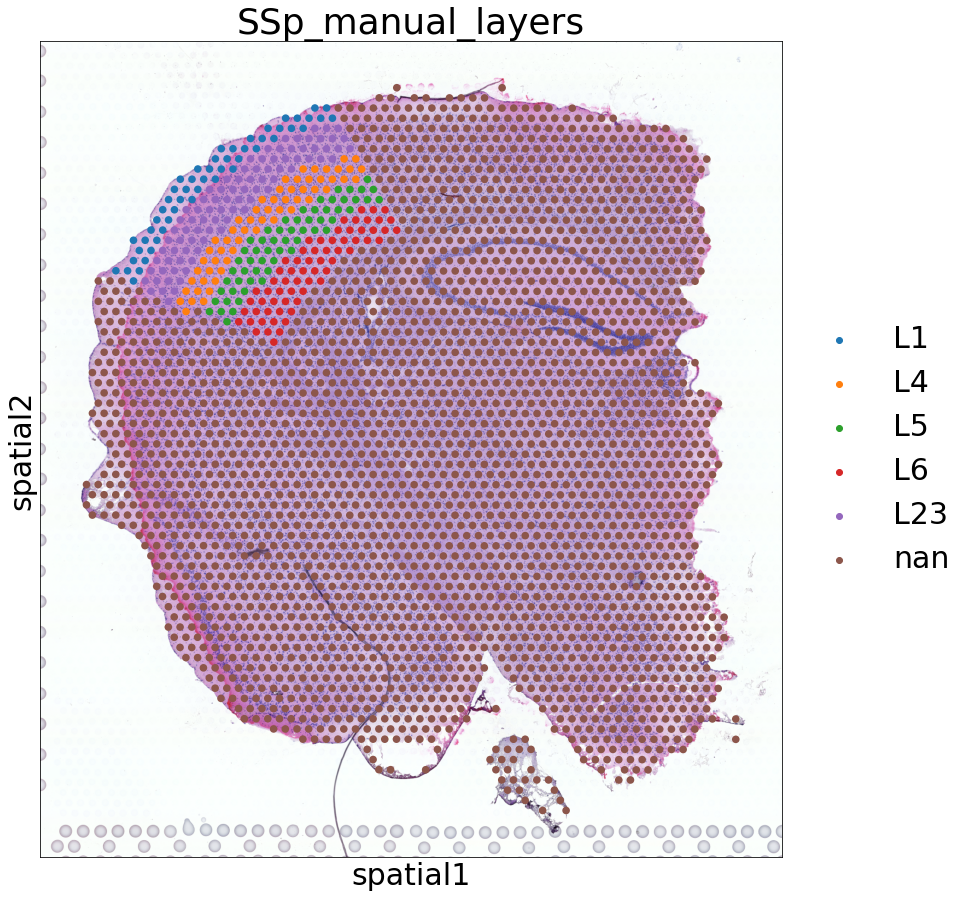

In [6]:
with matplotlib.rc_context({'axes.facecolor':  'white', 'figure.figsize': [15, 15], 'font.size': 30}):
    sc.pl.spatial(slides['ST8059048'], img_key = "hires", cmap='magma',
                  color=['SSp_manual_layers'], size=1,
                  gene_symbols='SYMBOL', ncols=1,
                  save='Fig2I_layers_full.pdf')

In [7]:
# filter to cortical regions
ind = ~ adata.obs['SSp_manual_layers'].isna()
adata = adata[ind, :]

for i in slides.keys():
    ind = ~ (np.array(slides[i].obs['SSp_manual_layers'].isna()) \
             | np.array(slides[i].obs['SSp_manual_layers'].isin(['nan'])))
    slides[i] = slides[i][ind, :]

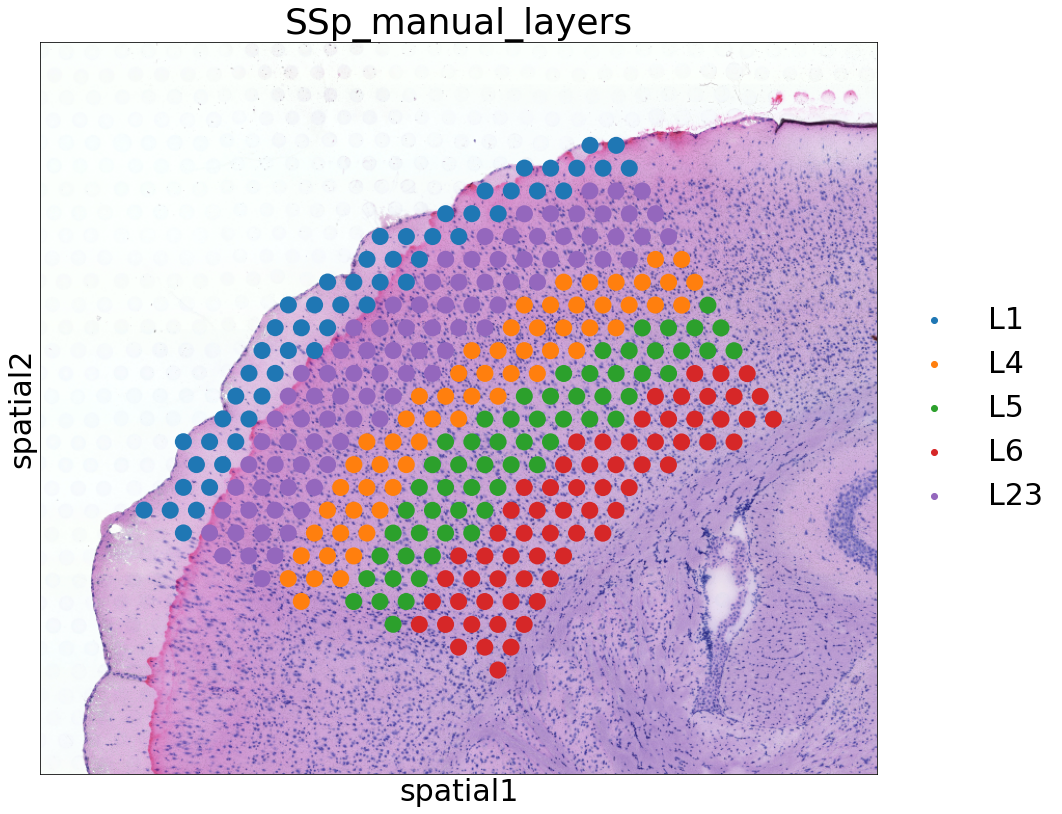

In [8]:
with matplotlib.rc_context({'axes.facecolor':  'white', 'figure.figsize': [15, 15], 'font.size': 30}):
    sc.pl.spatial(slides['ST8059048'], img_key = "hires", cmap='magma',
                  color=['SSp_manual_layers'], size=1,
                  gene_symbols='SYMBOL', ncols=1,
                  save='Fig2I_layers_zoom.pdf')

Now let's look at QC: total number of counts and total number of genes per spot

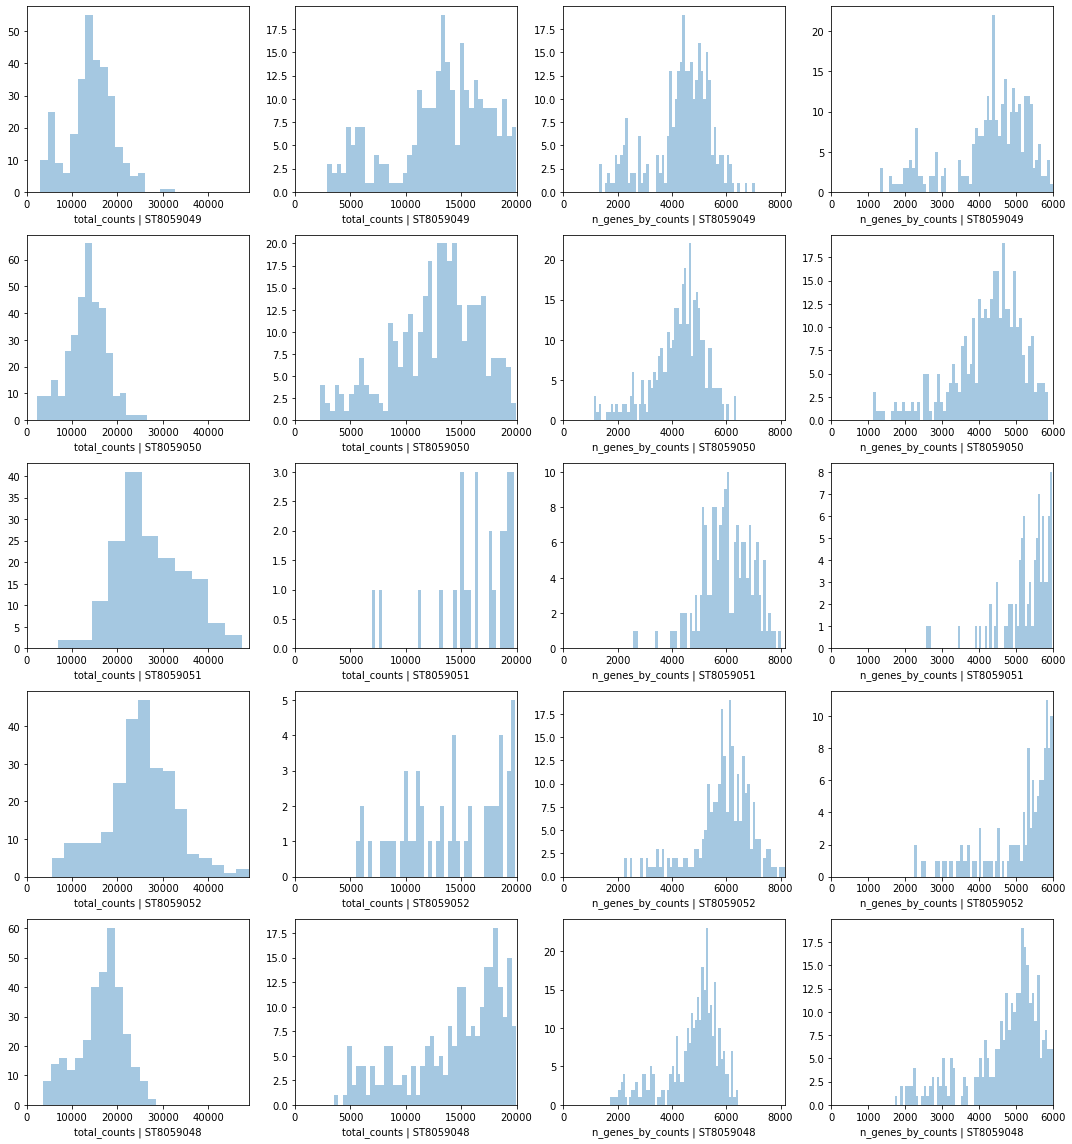

In [9]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

## Loading Allen single cell reference data <a class="anchor" id="read_allen"></a>

Mouse data:   
```bash
cd /nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/ && wget https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/49/6e/496ea0c2-25ae-4523-bb84-8d51a63ab72e/readme_mouse.txt
cd /nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/ && wget https://transcriptomic-viewer-downloads.s3-us-west-2.amazonaws.com/mouse/sample-annotations.zip
cd /nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/ && wget https://transcriptomic-viewer-downloads.s3-us-west-2.amazonaws.com/mouse/transcriptome.zip
cd /nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/ && wget https://transcriptomic-viewer-downloads.s3-us-west-2.amazonaws.com/mouse/dendrogram.zip
cd /nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/ && wget https://transcriptomic-viewer-downloads.s3-us-west-2.amazonaws.com/mouse/taxonomy.zip
```

```python
def extract_sparse_matrix(h5f, data_path):   
    r""" Read Allen data h5 file format into sparse matrix
    :param h5f: "h5f" is the handle that you get from "h5py.File('mouse/transcrip.tome')"
    :param data_path: "data_path" is the path within the archive.  In this case probably 
    either "/data/exon/" or "/data/intron/".
    """
    data = h5f[data_path]
    x = data['x']
    i = data['i']
    p = data['p']
    dims = data['dims']   
    
    sparse_matrix = ss.csc_matrix((x[0:x.len()], 
                                   i[0:i.len()], 
                                   p[0:p.len()]), 
                                  shape = (dims[0], dims[1]))    
    return sparse_matrix

# Open the file and import exon and intron data as sparse matrices
h5f = h5py.File(sc_data_folder + 'transcrip.tome')
exons = extract_sparse_matrix(h5f, '/data/exon/')
introns = extract_sparse_matrix(h5f, '/data/intron/')

# combine introns and exons
counts = introns + exons

# read cell and gene names
from re import sub
gene_names = pd.Series([sub("b\'|\'", '', str(i)) for i in np.array(h5f['gene_names'])])
sample_names = pd.Series([sub("b\'|\'", '', str(i)) for i in np.array(h5f['sample_names'])])

# read cell annotations
sample_meta = pd.DataFrame(np.array([[sub("b\'|\'", '', str(i)) for i in np.array(h5f['sample_meta']['anno'][i])] 
                                       for i in np.array(h5f['sample_meta']['anno'])]).T,
                           columns=np.array(h5f['sample_meta']['anno']),
                           index=sample_names)

# extract tSNE coordinates of cells
tsne = pd.DataFrame(np.array(h5f['projection']['tsne']))
tsne.index = [sub("b\'|\'", '', str(i)) for i in tsne['sample_name']]
tsne = tsne.reindex(index=sample_meta.index)
tsne = tsne[['x', 'y']].values

# create anndata object
adata_snrna_raw = anndata.AnnData(counts,obs=sample_meta)
adata_snrna_raw.var_names = gene_names
adata_snrna_raw.obsm['tsne'] = tsne

# remove cells with no TSNE coordinates
adata_snrna_raw = adata_snrna_raw[np.isnan(adata_snrna_raw.obsm['tsne']).sum(1) == 0,:]

# save all cells as h5ad
adata_snrna_raw.write(sc_data_folder + 'all.h5ad')
```

```python
adata_snrna_raw = anndata.read(sc_data_folder + 'all.h5ad')

# cells present in our sections
plus_v1 = ['AI', 'AUD', 'GU', 'HIP', 'RSP', 'SSp', 'SSs', 'SUB-ProS', 'TEa-PERI-ECT']
plus_v2 = ['AI', 'AUD', 'ENT1', 'GU', 'HIP', 'RSP', 'SSp', 'SSs', 'SUB-ProS', 'TEa-PERI-ECT', 'VIS']

# cells that should not be in our sections
minus = ['PAR-POST-PRE']

# filter to the region we need & save subsets
plus_v1_minus_ind = adata_snrna_raw.obs['region_label'].isin(plus_v1+minus)
plus_v1_ind = adata_snrna_raw.obs['region_label'].isin(plus_v1)
plus_v2_minus_ind = adata_snrna_raw.obs['region_label'].isin(plus_v2+minus)
plus_v2_ind = adata_snrna_raw.obs['region_label'].isin(plus_v2)
SSp_ind = adata_snrna_raw.obs['region_label'].isin(['SSp'])
HIP_ind = adata_snrna_raw.obs['region_label'].isin(['HIP'])

adata_snrna_raw[plus_v1_minus_ind,:].write(sc_data_folder + 'plus_v1_minus_visium.h5ad')
adata_snrna_raw[plus_v1_ind,:].write(sc_data_folder + 'plus_v1_visium.h5ad')
adata_snrna_raw[plus_v2_minus_ind,:].write(sc_data_folder + 'plus_v2_minus_visium.h5ad')
adata_snrna_raw[plus_v2_ind,:].write(sc_data_folder + 'plus_v2_visium.h5ad')
adata_snrna_raw[SSp_ind,:].write(sc_data_folder + 'SSp_visium.h5ad')
adata_snrna_raw[HIP_ind,:].write(sc_data_folder + 'HIP_visium.h5ad')
```

In [10]:
adata_snrna_raw = anndata.read(sc_data_folder + 'SSp_visium.h5ad')
adata_snrna_raw.shape

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(5577, 45768)

In [11]:
# find clusters that have at least 3 cells in SSp
clust_filt = adata_snrna_raw.obs['cluster_label'].value_counts()
clust_filt = np.array(clust_filt.index)[clust_filt >= 3]

# filter out cells from rare clusters
adata_snrna_raw = adata_snrna_raw[adata_snrna_raw.obs['cluster_label'].isin(clust_filt), :]

In [12]:
sc.pp.filter_genes(adata_snrna_raw, min_cells=3)

adata_snrna_raw.var_names_make_unique()

adata_snrna_raw.shape

Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(5524, 38145)

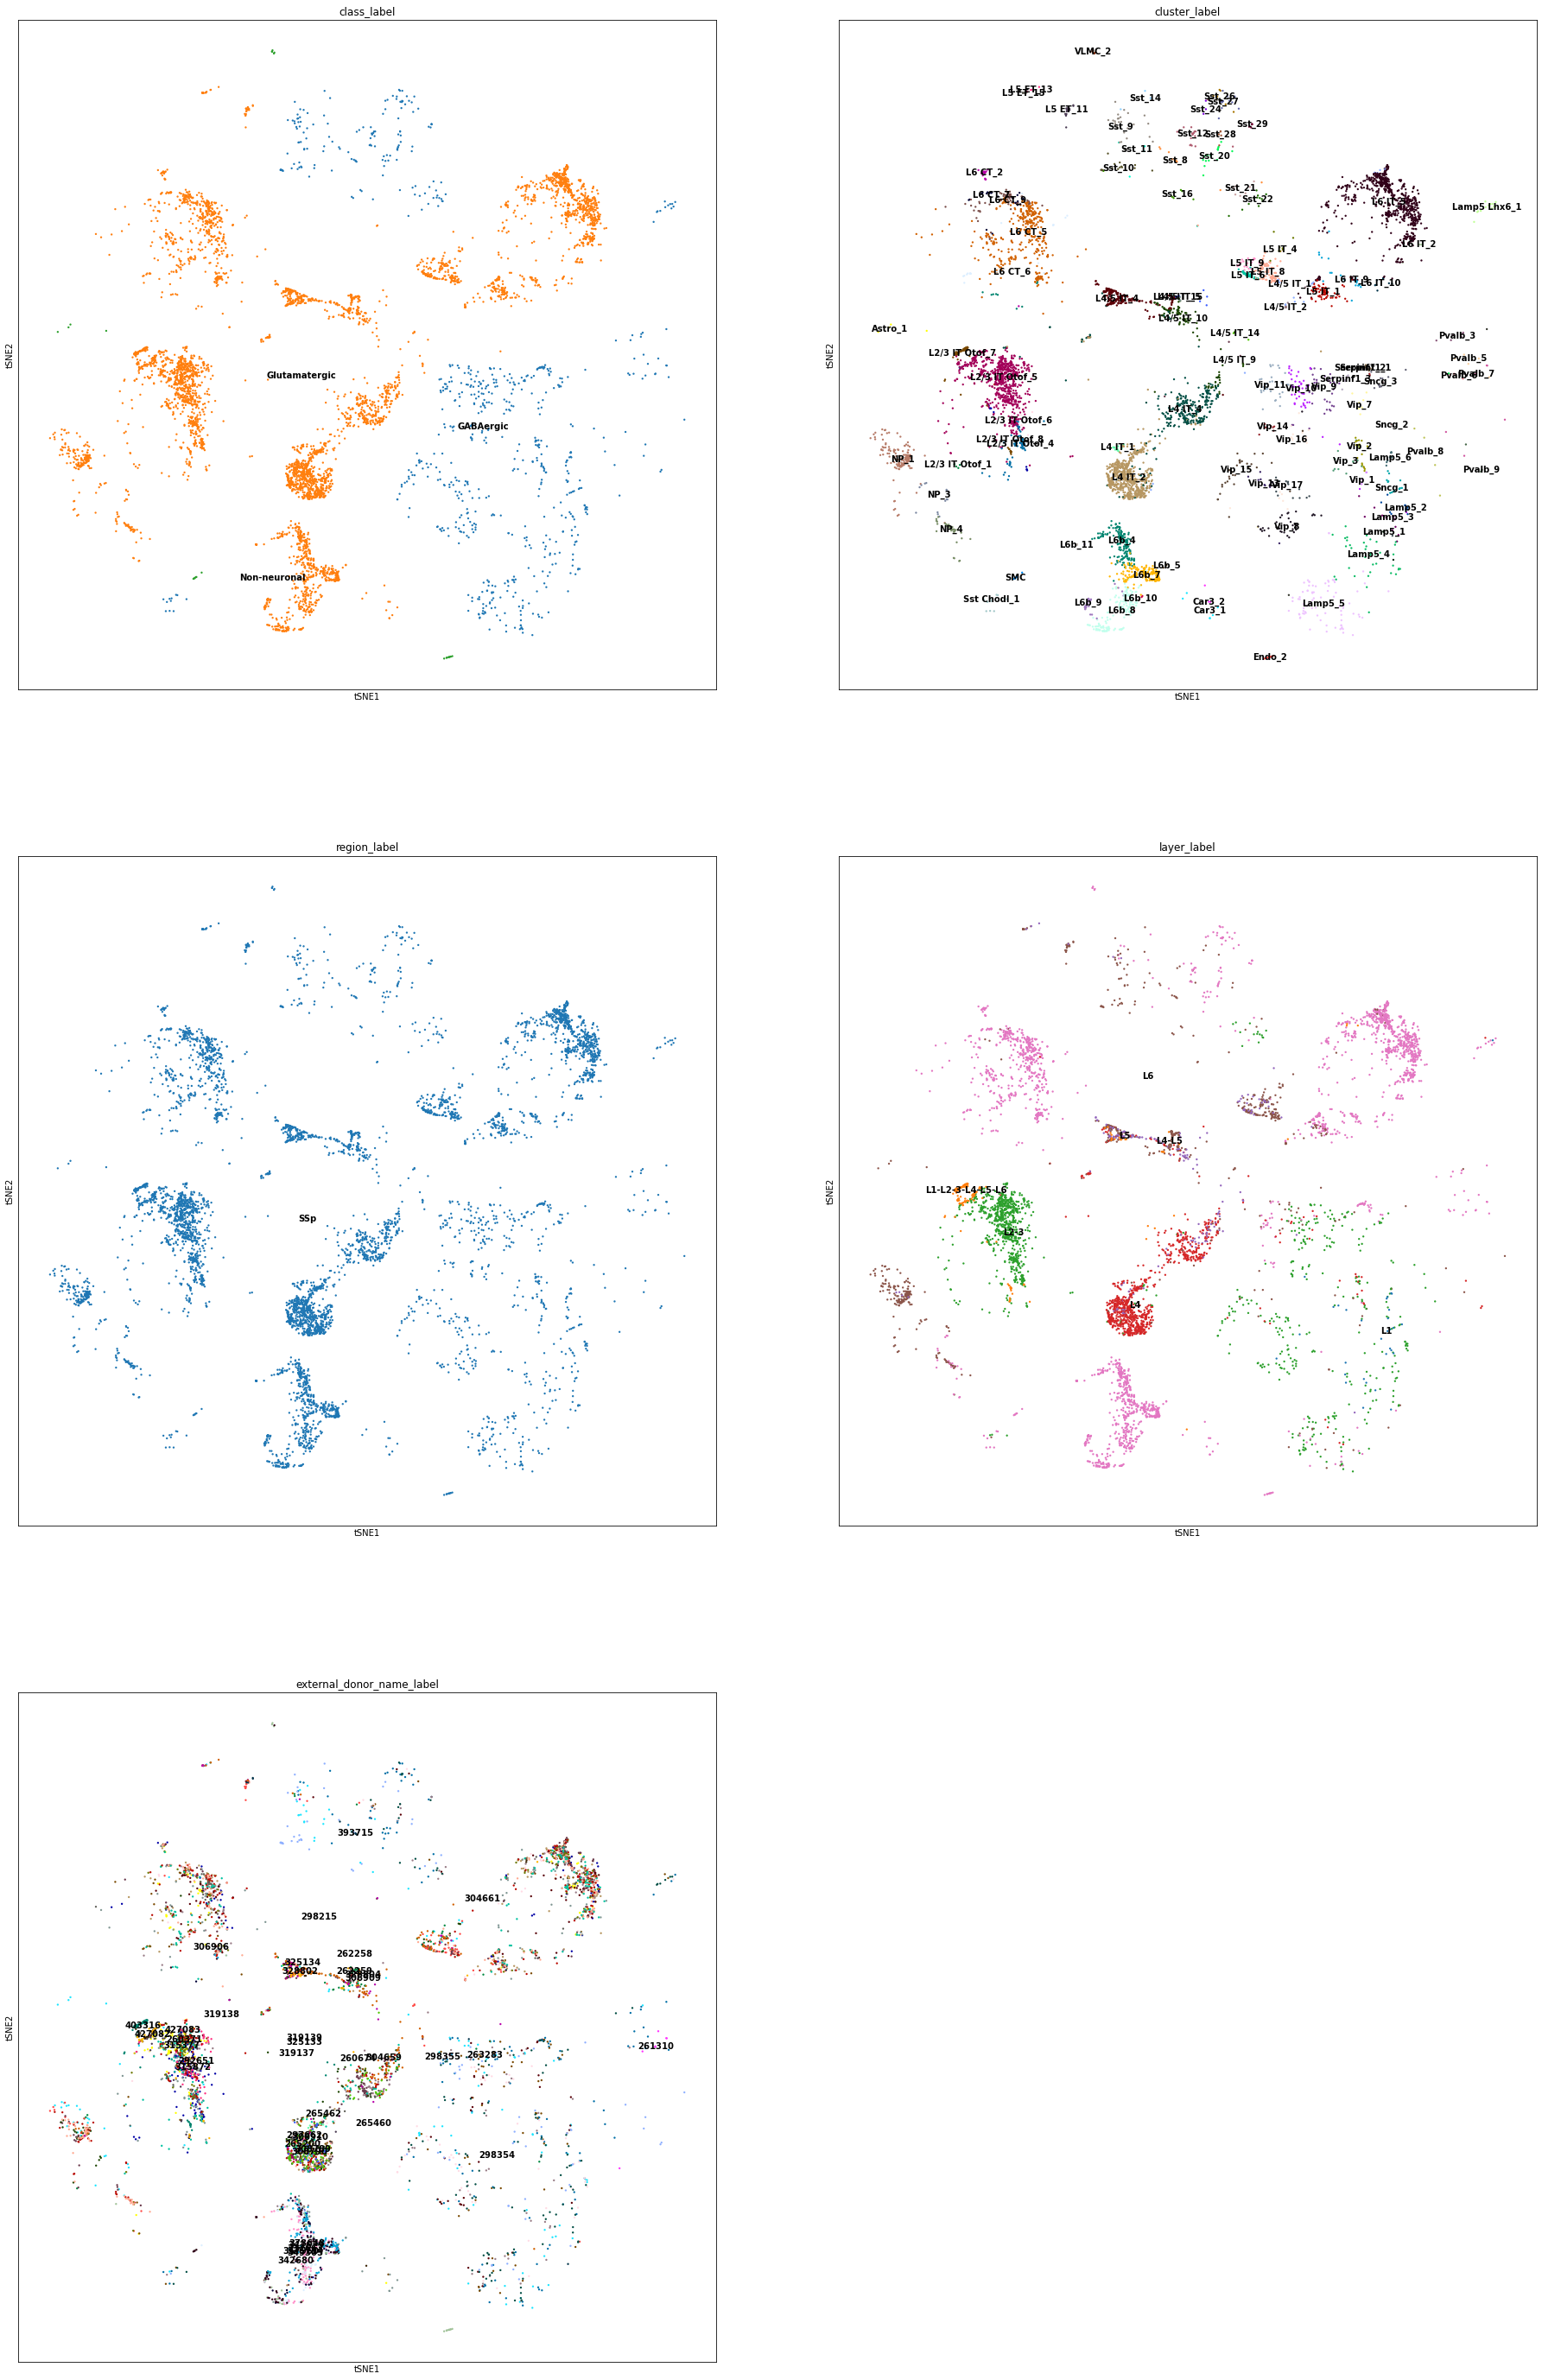

In [13]:
rcParams['figure.figsize'] = 15, 15
rcParams["axes.facecolor"] = "white"
sc.pl.tsne(adata_snrna_raw, color=['class_label', 'cluster_label', 'region_label', 
                                   'layer_label', 'external_donor_name_label'],
           color_map = 'RdPu', ncols = 2, legend_loc='on data',
           legend_fontsize=10)

Add counts matrix as `adata.raw` 

In [14]:
adata_vis = adata.copy()

sc.pp.filter_genes(adata_vis, min_cells=10)

adata_vis.var['ENSEMBL'] = adata_vis.var_names
adata_vis.var_names = adata_vis.var['SYMBOL']
adata_vis.var = adata_vis.var.drop(columns=['SYMBOL'])
adata_vis

AnnData object with n_obs × n_vars = 1393 × 15459
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample_name', 'sample_name2', 'image_name', 'slide', 'position', 'SSp_manual_layers'
    var: 'feature_types', 'genome', 'mt', 'n_cells_by_counts-ST8059048', 'mean_counts-ST8059048', 'log1p_mean_counts-ST8059048', 'pct_dropout_by_counts-ST8059048', 'total_counts-ST8059048', 'log1p_total_counts-ST8059048', 'n_cells_by_counts-ST8059049', 'mean_counts-ST8059049', 'log1p_mean_counts-ST8059049', 'pct_dropout_by_counts-ST8059049', 'total_counts-ST8059049', 'log1p_total_counts-ST8059049', 'n_cells_by_counts-ST8059050', 'mean_counts-ST8059050', 'log1p_mean_counts-ST8059050', 'pct_dropout_by_counts-ST8059050', 'total_counts-ST8059050', 'log1p_total_counts-ST8059050', 'n_c

In [15]:
adata_vis.raw = adata_vis
adata_snrna_raw.raw = adata_snrna_raw

## cell2location analysis  <a class="anchor" id="cell2location"></a>

Here we show how to perform the first step in one function run - train cell2location model to learn cell locations. Results are shown below and saved to:  

In [16]:
results_folder + 'allen_ref/'

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/allen_ref/'

In [26]:
from pycell2location.models.CoLocationModelNB4E6V2 import CoLocationModelNB4E6V2
r = cell2location.run_cell2location(
                      sc_data=adata_snrna_raw, 
                      sp_data=adata_vis,
                      model_name=CoLocationModelNB4E6V2,
                      verbose=True, return_all=False,
                      
                      summ_sc_data_args={'cluster_col': "cluster_label"},
                                      
                      train_args={'use_raw': True,
                                  'n_iter': 30000, 'learning_rate': 0.005,
                                  'sample_prior': False, # set to false for large spatial data 
                                  'readable_var_name_col': "ENSEMBL",
                                  'sample_name_col': 'sample'},
                                      
                      posterior_args={'n_samples': 500},
                                      
                      export_args={'path': results_folder + 'allen_ref/', 
                                   'run_name_suffix': '_n_comb150_mean_var5_30k',
                                   'save_model': False,
                                   'scanpy_coords_name': 'spatial', 'export_q05': True},
    
                      model_kwargs={ # Prior on the number of cells, cell types and co-located combinations
          
                    'cell_number_prior': {
                        # Use visual inspection of the tissue image to determine 
                        # the average number of cells per spot,
                        # an approximate count is good enough:
                        'cells_per_spot': 8, 
                        # Prior on the number of cell types (or factors) in each spot
                        'factors_per_spot': 7, 
                        # Prior on the number of correlated cell type combinations in each spot
                        'combs_per_spot': 6
                    },
          
                     # Prior on change in sensitivity between technologies
                    'gene_level_prior':{
                        # Prior on average change in expression level from scRNA-seq to spatial technology,
                        # this reflects your belief about the sensitivity of the technology in you experiment
                        'mean': 1/20, 
                        # Prior on how much individual genes differ from that average,
                        # a good choice of this value should be lower that the mean
                        'sd': 1/40
                    },
                          
                     # The number of co-located cell type combinations
                    'n_comb': 150, 'spot_fact_mean_var_ratio': 5
      }
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Summarising single cell clusters ###
### Creating model ### - time 0.24 min
### Analysis name: CoLocationModelNB4E6V2_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k
### Training model ###


Finished [100%]: Average Loss = 1.534e+07


Finished [100%]: Average Loss = 1.534e+07



### Sampling posterior ### - time 16.33 min



### Saving results ###


... storing 'feature_types' as categorical
... storing 'genome' as categorical


### Ploting results ###


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Plotting posterior of W / cell locations ###


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Done ### - time 17.52 min


Trained model object can be pulled from `r['mod']`, cell locations are added to `r['sp_data']` as columns of `sp_data.obs` and all paramters of the model are exported to `sp_data.uns['mod']`. This anndata object and a csv file `W.csv` / `W_q05.csv` with cell locations are always saved to the results directory. 

When `'save_model': True`, the trained model `r['mod']` is also saved as a pickle file. You can load the model later and continue training. 

Now we need to check if our model has trained successfully by looking at the loss / cost function over training iterations. This plot omits the first 20% of training iterations during which loss changes by orders of magnitude.

#### Evaluating training

In [17]:
run = {'run_name': 'CoLocationModelNB4E6V2_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k'}

# path for saving figures
fig_path = f'{results_folder}{run["run_name"]}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

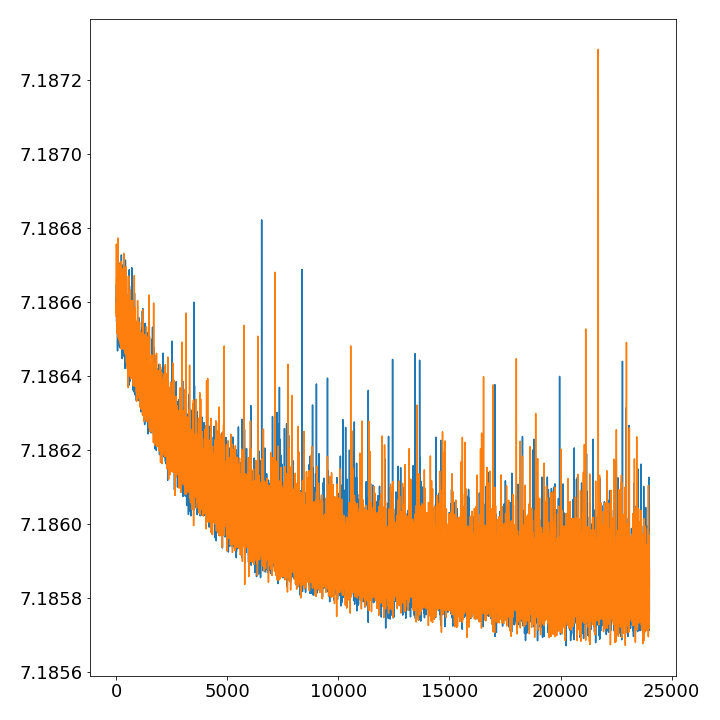

In [18]:
from IPython.display import Image
Image(filename=results_folder+run['run_name']+'/plots/training_history_without_first_20perc.png',
      width=400)

We also need to evaluate the reconstruction accuracy or how well cell types and uniform background explain spatial data bu comparing expected value of the model (Poisson mean) to observed count of each gene across locations. The ideal case is perfect diagonal plot.

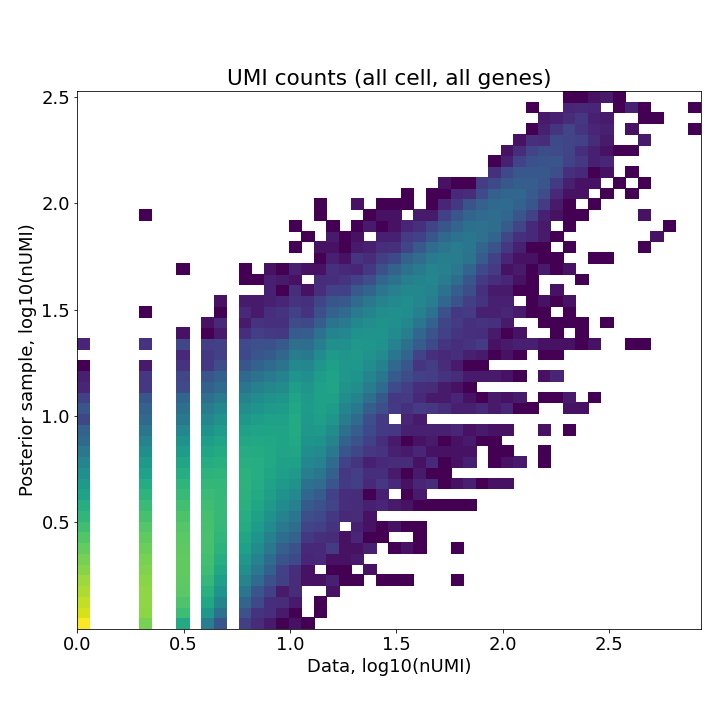

In [19]:
Image(filename=results_folder +run['run_name']+'/plots/data_vs_posterior_mean.png',
      width=400)

Finally, we need to evaluate robustness of the identified locations by comparing consistency of inferred locations between two independent training restarts.

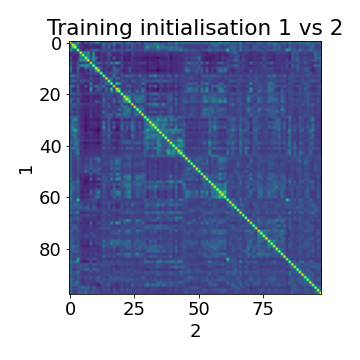

In [20]:
Image(filename=results_folder +run['run_name']+'/plots/evaluate_stability.png',
      width=400)

### Loading cell2location results <a class="anchor" id="cell2location_res"></a>

Alternatively we can load the results of the model saved into `sp_data`:

In [21]:
sp_data_file = results_folder +run['run_name']+'/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


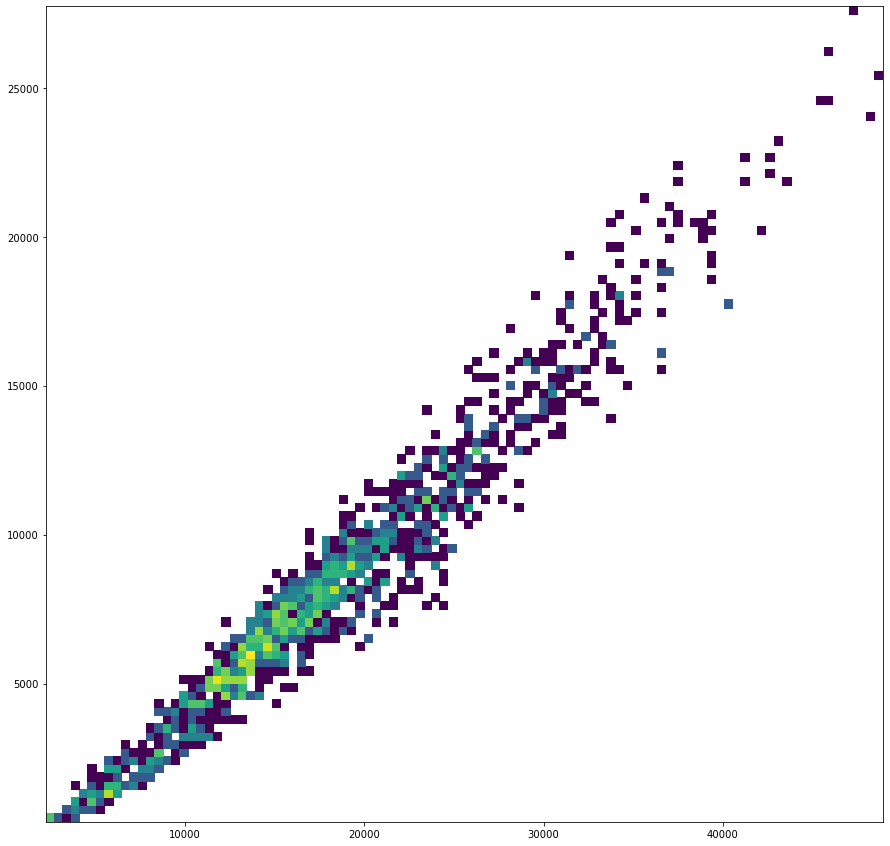

In [22]:
plt.hist2d(adata_vis.obs['total_counts'].values,
           adata_vis.uns['mod']['post_sample_q05']['nUMI_factors'].sum(1).flatten(),
           bins=100, norm=matplotlib.colors.LogNorm());

#### Advanced plotting of cell locations

Here we visualise locations of multiple cell types at once.

In [23]:
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata_vis[adata_vis.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

### Evaluate mapping accuracy by comparing to Allen <a class="anchor" id="mapping_accuracy"></a>

In [24]:
# Define functions that compute per layer average abundance of each cell type & plot annotated scatterplot
def layer_distribution(slide, lay=None, layer_col='SSp_manual_layers', 
                       post_type='mean_spot_factors', 
                       summary_fun=np.mean, proportion_per_layer=False):
    
    sel_clust_col = [post_type in i for i in slide.obs.columns]
    sel_clust_col = slide.obs.columns[sel_clust_col]
    from re import sub # create nice names
    sel_clust = [sub(post_type, '', i) for i in sel_clust_col]

    # log-transform and save with nice names
    #slides[s].obs[sel_clust] = np.log10(slides[s].obs[sel_clust_col])
    infer_lay_df = slide.obs[sel_clust_col]
    infer_lay_df.columns = sel_clust

    infer_lay = pd.DataFrame(index=sel_clust)
    for r in slide.obs[layer_col].unique():
        ind = slide.obs[layer_col].isin([r])
        # sum / mean of cell density across all spots within a region
        infer_lay[r] = summary_fun(infer_lay_df.loc[ind, :], axis=0)
    
    infer_lay = infer_lay[['L1', 'L23', 'L4', 'L5', 'L6']]
    infer_lay.columns = ['L1', 'L2-3', 'L4', 'L5', 'L6']
    infer_lay = infer_lay.loc[infer_lay.sum(1) > 0, :]
    if lay is not None:
        infer_lay = infer_lay.loc[lay.index, :]
    infer_lay = infer_lay.loc[np.sort(list(infer_lay.index)), :]
    
    # convert to proportions per layer
    if proportion_per_layer is True:
        infer_lay = infer_lay / infer_lay.sum(0)
    
    return infer_lay

def plot_hist2d(x, y, xlab, ylab, log=False, scatter_kwdargs:dict={}):
    
    corr = np.corrcoef(
        x.values.flatten(), 
        y.values.flatten())[0,1]
    corr_log10 = np.corrcoef(
        np.log10(x.values.flatten() + 1), 
        np.log10(y.values.flatten() + 1))[0,1]

    if log:
        x = np.log10(x.values.flatten() + 1)
        y = np.log10(y.values.flatten() + 1)
        
        xlab = xlab + ' (log10)'
        ylab = ylab + ' (log10)'
    else:
        x = x.values.flatten()
        y = y.values.flatten()

    #plt.hist2d(x, y, bins=35, norm=matplotlib.colors.LogNorm());
    plt.scatter(x, y, **scatter_kwdargs);
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    plt.xlim(0);
    plt.ylim(0);
    plt.title(r'$R^2$: ' \
              + str(np.round(corr, 3))\
              #+ r', $R^2$ log: '+ str(np.round(corr_log10, 3))
             );

Using the data from all animals

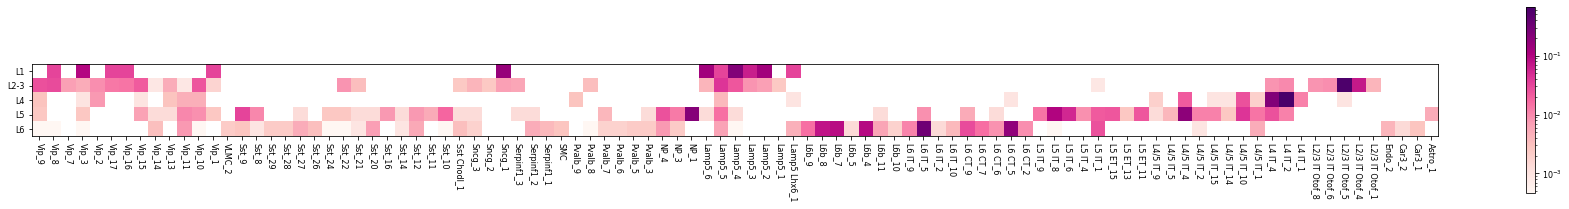

In [25]:
lay = pd.DataFrame(index=adata_snrna_raw.obs['cluster_label'].unique())
for r in adata_snrna_raw.obs['layer_label'].unique():
    ind = adata_snrna_raw.obs['layer_label'].isin([r])
    lay[r] = adata_snrna_raw.obs.loc[ind, 'cluster_label'].value_counts()
    
lay = lay[['L1', 'L2-3', 'L4', 'L5', 'L6']]
lay = lay.loc[lay.sum(1) > 0, :]
lay = lay.loc[np.sort(list(lay.index)), :]
lay = lay / lay.sum(0)

rcParams["font.size"] = 8
rcParams["axes.facecolor"] = "white"
clustermap(lay.T, figure_size=(25, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False)

Using the layer map in one section

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call 

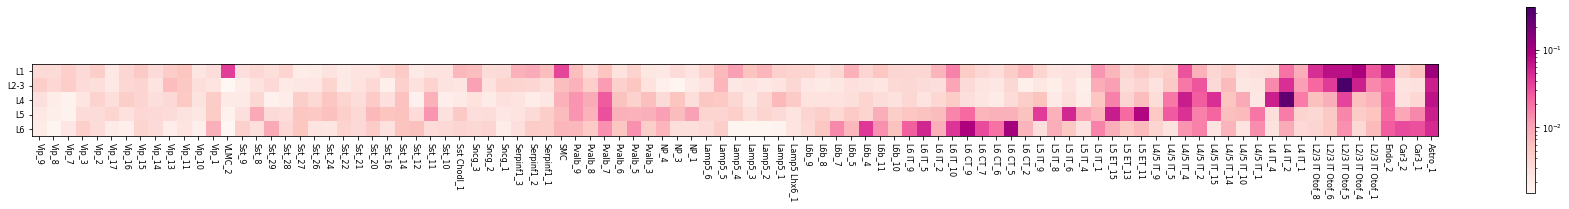

In [26]:
infer_lay_ST8059048 = layer_distribution(select_slide(adata_vis, 'ST8059048').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059049 = layer_distribution(select_slide(adata_vis, 'ST8059049').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059051 = layer_distribution(select_slide(adata_vis, 'ST8059051').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059052 = layer_distribution(select_slide(adata_vis, 'ST8059052').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)

infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay.index,:]
infer_lay_ST8059048 = infer_lay_ST8059048 / infer_lay_ST8059048.sum(0)

rcParams["font.size"] = 8
rcParams["axes.facecolor"] = "white"
clustermap(infer_lay_ST8059048.T, figure_size=(25, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False)

### Fig 2J <a class="anchor" id="Fig2J"></a>

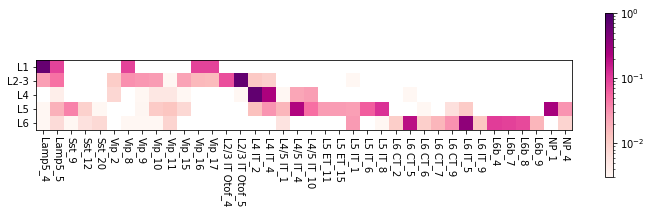

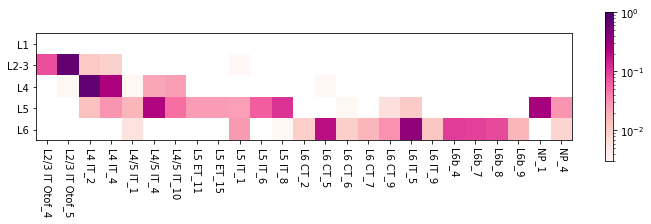

In [27]:
lay = pd.DataFrame(index=adata_snrna_raw.obs['cluster_label'].unique())
for r in adata_snrna_raw.obs['layer_label'].unique():
    ind = adata_snrna_raw.obs['layer_label'].isin([r])
    lay[r] = adata_snrna_raw.obs.loc[ind, 'cluster_label'].value_counts()

# reorder according to broad class
broad_class = adata_snrna_raw.obs[['class_label', 'cluster_label']].drop_duplicates()
broad_class.index = broad_class['cluster_label']
broad_class = broad_class.drop(columns='cluster_label')
broad_class = broad_class.sort_values(['class_label', 'cluster_label'], ascending=False)
index = list(broad_class.index)
lay = lay.loc[index, :]

    
lay = lay[['L1', 'L2-3', 'L4', 'L5', 'L6']]
lay = lay.loc[lay.sum(1) > 15, :]
lay = lay / lay.sum(0)

rcParams["font.size"] = 10
rcParams["axes.facecolor"] = "white"
clustermap(lay.T, figure_size=(10, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           vmin=0.003, vmax=1)
plt.savefig(f'{fig_path}Fig2J_suppl_reference.pdf', bbox_inches='tight')
plt.show()

rcParams["font.size"] = 10
rcParams["axes.facecolor"] = "white"
index_subset = list(broad_class[broad_class['class_label'].isin(['Glutamatergic'])].index)
index_subset = np.array(index_subset)[np.isin(index_subset, lay.index)]
lay_subset = lay.loc[index_subset,:].T
clustermap(lay_subset, 
           figure_size=(10, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           vmin=0.003, vmax=1)
plt.savefig(f'{fig_path}Fig2J_reference.pdf', bbox_inches='tight')
plt.show()

Using the layer map in one section

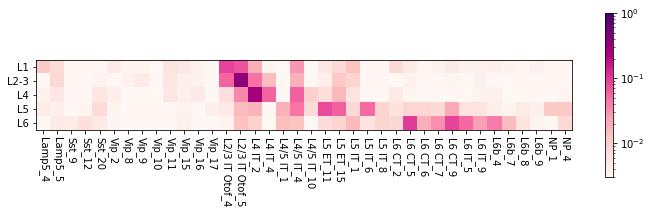

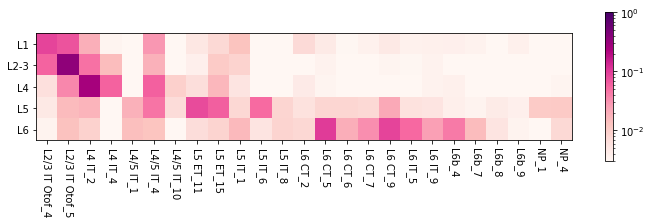

In [28]:
infer_lay_ST8059048 = infer_lay_ST8059048 / infer_lay_ST8059048.sum(0)
infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay.index,:]

rcParams["font.size"] = 10
rcParams["axes.facecolor"] = "white"
infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay.index, :]
clustermap(infer_lay_ST8059048.T, figure_size=(10, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           vmin=0.003, vmax=1)
plt.savefig(f'{fig_path}Fig2J_suppl_map.pdf', bbox_inches='tight')
plt.show()

rcParams["font.size"] = 10
rcParams["axes.facecolor"] = "white"
infer_lay_ST8059048_subset = infer_lay_ST8059048.loc[index_subset,:].T
clustermap(infer_lay_ST8059048_subset, figure_size=(10, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           vmin=0.003, vmax=1)
plt.savefig(f'{fig_path}Fig2J_map.pdf', bbox_inches='tight')
plt.show()

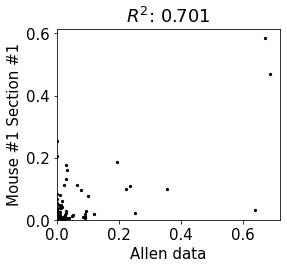

In [29]:
with matplotlib.rc_context({'axes.facecolor': 'white', 'font.size': 15,
                            'figure.figsize': [4, 4]}):
    
    infer_lay_ST8059048 = infer_lay_ST8059048 / infer_lay_ST8059048.sum(0)
    infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay.index, :]
    
    plot_hist2d(lay, infer_lay_ST8059048, 
                'Allen data', 
                'Mouse #1 Section #1', 
               scatter_kwdargs={'s': 5, 'c': 'black'})
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('figures/Allen_reference_vs_cell2location.pdf', bbox_inches='tight')
    
    plt.show()

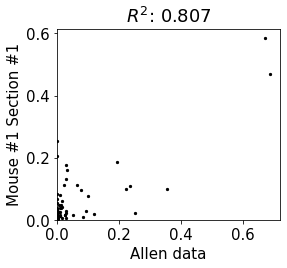

In [31]:
with matplotlib.rc_context({'axes.facecolor': 'white', 'font.size': 15,
                            'figure.figsize': [4, 4]}):
    
    infer_lay_ST8059048 = infer_lay_ST8059048 / infer_lay_ST8059048.sum(0)
    infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay.index, :]
    
    
    index_subset = list(broad_class[broad_class['class_label'].isin(['Glutamatergic'])].index)
    index_subset = np.array(index_subset)[np.isin(index_subset, infer_lay_ST8059048.index)]
    infer_lay_ST8059048_subset = infer_lay_ST8059048.loc[index_subset,:].T
    lay_subset = lay.loc[index_subset,:].T
    
    plot_hist2d(lay_subset, infer_lay_ST8059048_subset, 
                'Allen data', 
                'Mouse #1 Section #1', 
               scatter_kwdargs={'s': 5, 'c': 'black'})
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('figures/Allen_reference_vs_cell2location_Glutamatergic.pdf', bbox_inches='tight')
    
    plt.show()

### Fig 2J supplementary spatial maps <a class="anchor" id="suppl_spatial_maps"></a>

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


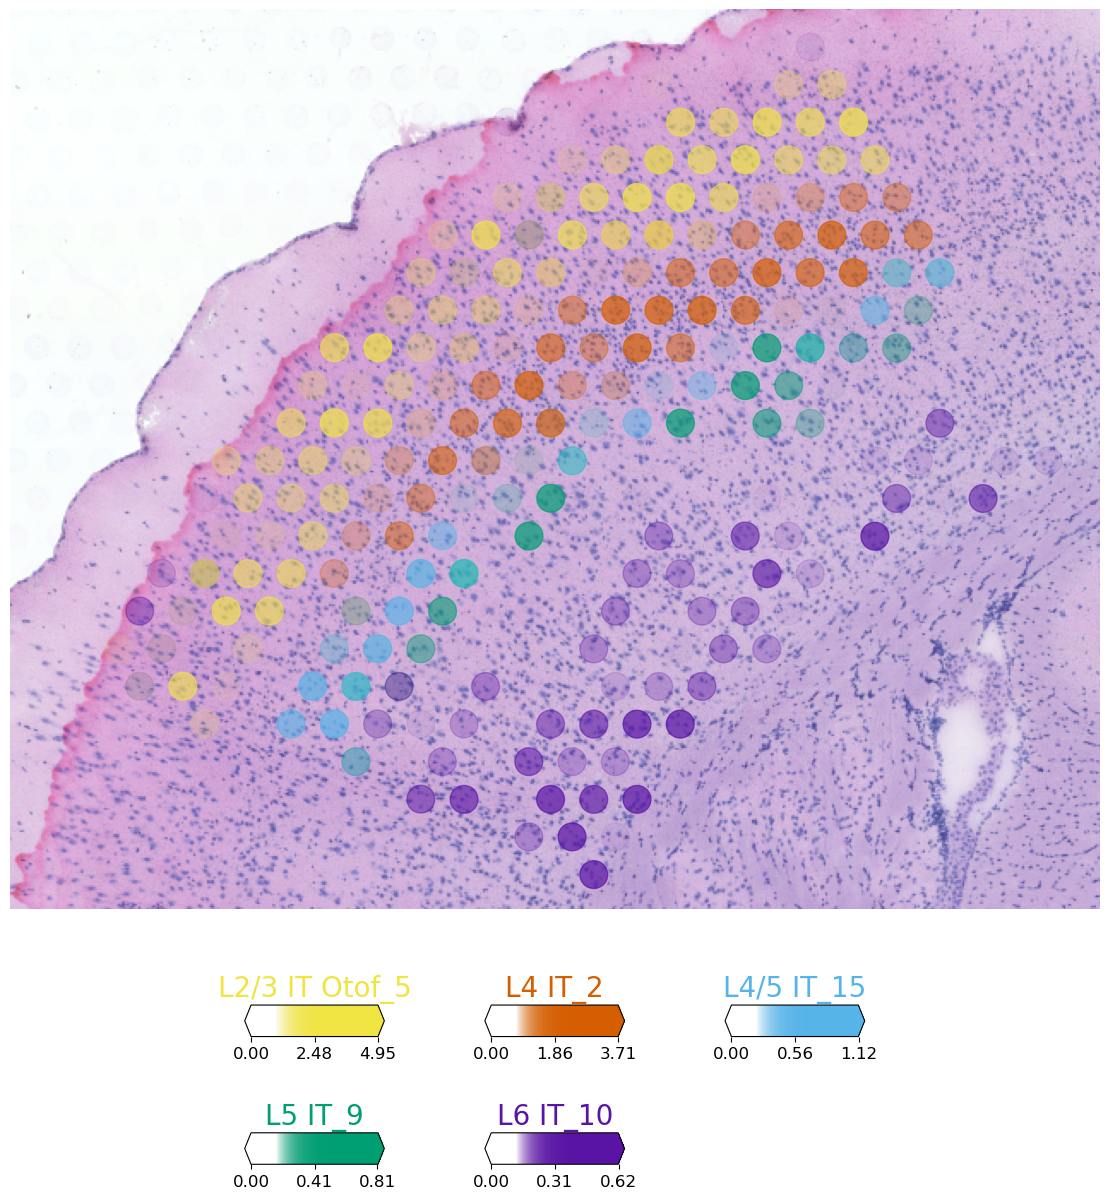

In [32]:
from cell2location.plt.mapping_video import plot_spatial

# identify spot locations to crop near tissue
crop_max = (slides[s].obsm['spatial'] * list(slides[s].uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
crop_min = (slides[s].obsm['spatial'] * list(slides[s].uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

crop_x = [crop_min[0]-0, crop_max[0]+30]
crop_y = [crop_max[1]+20, crop_min[1]-0]

sel_clust = ['L2/3 IT Otof_5', 'L4 IT_2', 'L4/5 IT_15', 'L5 IT_9', 'L6 IT_10']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

slide = select_slide(adata_vis, 'ST8059048')

matplotlib.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with matplotlib.rc_context({"figure.figsize": (16,15)}):
    plot_spatial((slide.obs[sel_clust_col]), labels=sel_clust,
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
                  show_img=True, img_alpha=0.85,
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=20, alpha_scaling=0.7,
                  plt_axis='off', axis_y_flipped=False,
                  crop_x=crop_x, crop_y=crop_y)

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


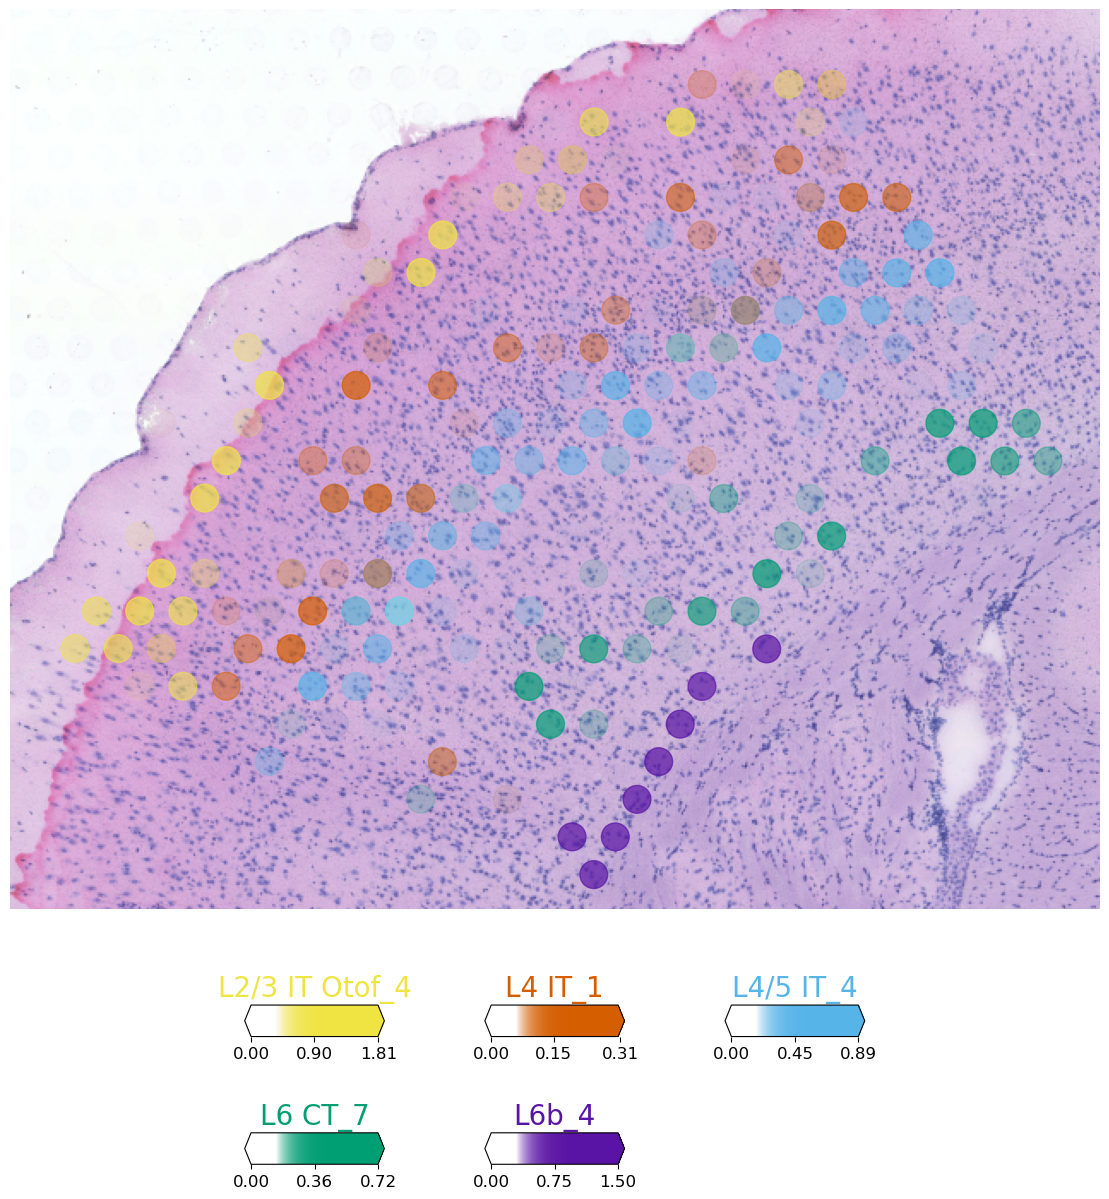

In [33]:
# identify spot locations to crop near tissue
crop_max = (slides[s].obsm['spatial'] * list(slides[s].uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
crop_min = (slides[s].obsm['spatial'] * list(slides[s].uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

crop_x = [crop_min[0]-0, crop_max[0]+30]
crop_y = [crop_max[1]+20, crop_min[1]-0]

sel_clust = ['L2/3 IT Otof_4', 'L4 IT_1', 'L4/5 IT_4', 'L6 CT_7', 'L6b_4']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

slide = select_slide(adata_vis, 'ST8059048')

matplotlib.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with matplotlib.rc_context({"figure.figsize": (16,15)}):
    plot_spatial((slide.obs[sel_clust_col]), labels=sel_clust,
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
                  show_img=True, img_alpha=0.85,
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=20, alpha_scaling=0.7,
                  plt_axis='off', axis_y_flipped=False,
                  crop_x=crop_x, crop_y=crop_y)

In [34]:
results_folder +run['run_name']

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/CoLocationModelNB4E6V2_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k'

In [34]:
! ~/gdrive upload --parent 1duXZkDqJsuDmubyMHHk9W3rusmWbpCLo --recursive /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/CoLocationModelNB4E6V2_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k

Creating directory CoLocationModelNB4E6V2_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/CoLocationModelNB4E6V2_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k/model_.p
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/CoLocationModelNB4E6V2_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k/W_mRNA_count.csv
Creating directory plots                          
Creating directory figures
Creating directory .ipynb_checkpoints
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/CoLocationModelNB4E6V2_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k/plots/figures/Fig2J_suppl_map.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/CoLocationModelNB4E6V2_98clusters_139

Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/CoLocationModelNB4E6V2_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k/plots/spatial/spatialhisto_W_mRNA_count_q05_ST8059049_p99.2.png
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/CoLocationModelNB4E6V2_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k/plots/spatial/spatialW_cell_density_mean_ST8059049_p99.2.png
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/CoLocationModelNB4E6V2_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k/plots/spatial/spatialhisto_W_cell_density_q05_ST8059052_p99.2.png
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/CoLocationModelNB4E6V2_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k/plots/spatial/spatialW_mRNA_count_q05_ST8

Modules and their versions used for this analysis

In [35]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.0
ipykernel._version 5.3.0
json 2.0.9
re 2.2.1
IPython 7.15.0
IPython.core.release 7.15.0
logging 0.5.1.2
zlib 1.0
traitlets 4.3.3
six 1.15.0
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
traitlets._version 4.3.3
decorator 4.4.2
argparse 1.1
pygments 2.6.1
pexpect 4.8.0
ptyprocess 0.6.0
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.5
wcwidth 0.2.5
jedi 0.17.1
parso 0.7.0
urllib.request 3.7
jupyter_client 6.1.3
jupyter_client._version 6.1.3
zmq 19.0.1
ctypes 1.1.0
_ctypes 1.1.0
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.1
zmq.sugar.constants 40302
zmq.sugar.version 19.0.1
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.6
_curses b'2.2'
dateutil 2.8.1
decimal 1.70
_decimal 1.70
scanpy 1.6.0
numpy 1.19.1
numpy.core 1.19.1
numpy.core._multiarray_umath 3.1
numpy.lib 1.19.1
numpy.linalg._umath_linalg b'0.1.5'
scipy 1.5.2
scipy._lib._uarray 0.5.1+49.g4c3f1d7.scipy
anndata 0.7.4
h5py 2.10.0
natsort 7.0.1
pa